In [3]:
from __future__ import division
import math
import sys, site, os
import numpy as np
from scipy import optimize 
from scipy.special import comb
from scipy.stats import poisson
import scipy.optimize
import scipy.misc
from datetime import datetime
sys.path.append(os.path.abspath("auxiliary_scripts"))
from tnn import *
from global_vars import *
from jupyter_aux import *
import matplotlib.pyplot as plt



########### Mask Model PE Analysis -- Parellel ########### 
def PE(i, is_intermediate, E0, E1, T_list, m, mean_degree, max_degree):
    res = 0
    for k in range(0, max_degree):
        prob_r = poisson.pmf(k, mean_degree)
        
        if is_intermediate: # intermediate q using excess degree distribution
            pb = prob_r * k * 1.0 / mean_degree 
        else:
            pb = prob_r
            
        res += pb * PE_B(i, is_intermediate, k, E0, E1, T_list, m)
    return res

def PE_B(i, is_intermediate, k, E0, E1, T_list, m):
    res = 0
    one_minus_m = 1 - m
    
    if is_intermediate: # intermediate q, powers sum up to k - 1
        n_range = k
    else:               # generation 0, powers sum up to k
        n_range = k + 1
        
    for n in range(n_range):
        pe_bn = PE_BN(i, is_intermediate, n, k, E0, E1, T_list, m)
        res += pe_bn * comb(n_range - 1, n) * (m ** n) * (one_minus_m ** (n_range - 1 - n))
    return res

def PE_BN(i, is_intermediate, n, k, E0, E1, T_list, m):
    T1 = T_list[0]
    T2 = T_list[1]
    T3 = T_list[2]
    T4 = T_list[3]
    
    res = 0 
    
    if i == 0:
        t_mask = T2
        t_no_mask = T1
    else:
        t_mask = T4
        t_no_mask = T3
    
    one_minus_mask = 1 - t_mask
    one_minus_no_mask = 1 - t_no_mask
        
    if is_intermediate:
        k_range = k 
    else:
        k_range = k + 1
        
    for k0 in range(n + 1):
        for k1 in range(k_range - n):
            res += comb(n, k0) * (t_mask ** k0) * (one_minus_mask ** (n - k0)) *\
            comb(k_range - 1 - n, k1) * (t_no_mask ** k1) * (one_minus_no_mask ** (k_range - 1 - n - k1)) *\
            (E0 ** k0) * (E1 ** k1)
            
    return res

def PE_vec(mean_degree, is_intermediate,  T_list, m, E0, E1, max_degree):
    E0 = PE(0, is_intermediate, E0, E1, T_list, m, mean_degree, max_degree)
    E1 = PE(1, is_intermediate, E0, E1, T_list, m, mean_degree, max_degree)
    return np.array([E0, E1])

def func_root_pe(E, mean_degree, T_list, m, max_degree):
    return PE_vec(mean_degree, True, T_list, m, E[0], E[1], max_degree) - np.array(E)

def get_ProbEmergence(mean_degree, m, k_max, T_list, pe_list_m, pe_0_list_m, pe_1_list_m,):
    E0, E1 = optimize.fsolve(func_root_pe, (0.01, 0.01), args=(mean_degree, T_list, m, k_max), xtol=1e-6)    
    E0, E1 = 1 - PE_vec(mean_degree, False,  T_list, m, E0, E1, k_max)
    pe_list_m[mean_degree]   = m * E0 + (1 - m) * E1
    pe_0_list_m[mean_degree] = E0
    pe_1_list_m[mean_degree] = E1
    print(mean_degree, E0, E1)

In [4]:
m = 0.45
T = 0.6
tm1 = 0.3
tm2 = 0.7

q_dict, mu_dict = generate_new_transmissibilities_mutation(tm1, tm2, T, m)
T_list  = list(generate_new_transmissibilities_mask(tm1, tm2, T, m).values())
Q_list  = list(q_dict.values())
mu_list = list(mu_dict.values())

k_max = 20

In [21]:
mind = 0
maxd = 10
ns = 50
mean_degree_list_0to10 = np.linspace(mind, maxd, ns)

In [6]:
pe_list_m = dict()
pe_0_list_m = dict()
pe_1_list_m = dict()

for mean_degree in mean_degree_list:
    get_ProbEmergence(mean_degree, m, k_max, T_list, pe_list_m, pe_0_list_m, pe_1_list_m,)
    

/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0 0.0 0.0
0.20408163265306123 6.994405055138486e-15 2.353672812205332e-14
0.40816326530612246 4.4428904999449514e-12 1.4719669927387713e-11
0.6122448979591837 9.703349235223868e-14 3.207434318142077e-13
0.8163265306122449 4.0760728126088e-12 1.3415157873453154e-11
1.0204081632653061 7.290179571128874e-11 2.3963575568330953e-10
1.2244897959183674 1.1931566845646557e-12 3.921751812185903e-12
1.4285714285714286 1.5060952485157486e-11 4.954714416527395e-11
1.6326530612244898 1.1155198986756432e-10 3.6730407604324e-10
1.836734693877551 2.4522606167920458e-12 8.022360553638919e-12
2.0408163265306123 2.1009860518006462e-12 6.455058709775585e-12
2.2448979591836737 1.349131917294244e-11 4.201983205831539e-11
2.4489795918367347 1.8008627922228015e-10 5.86297455029694e-10
2.6530612244897958 0.017071115627389943 0.055778993445484426
2.857142857142857 0.0659034027457912 0.20327954604406906
3.0612244897959187 0.11061476026560224 0.32345026928148823
3.2653061224489797 0.15179475333686576 0.42234325

In [7]:
pe_0to10  = get_ordered_values_by_key(pe_list_m)
pe0_0to10 = get_ordered_values_by_key(pe_0_list_m)
pe1_0to10 = get_ordered_values_by_key(pe_1_list_m)

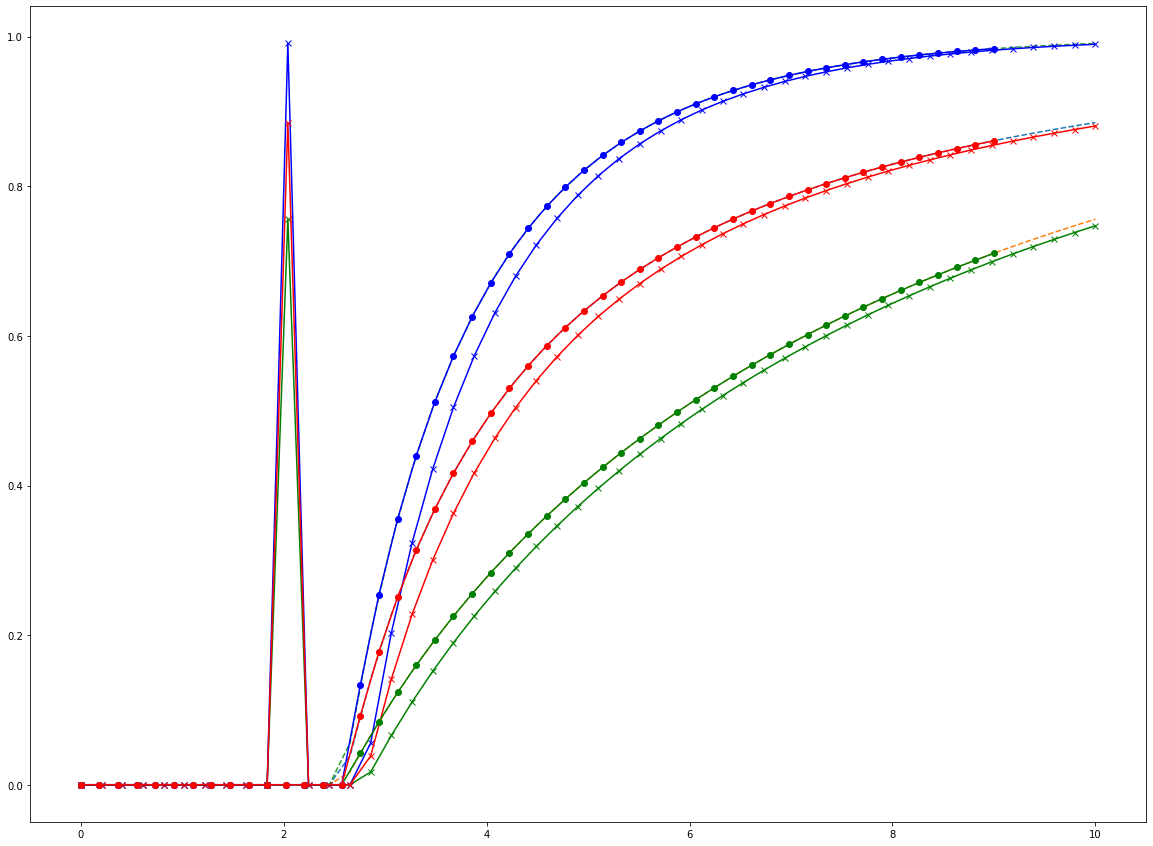

In [14]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(mean_degree_list, pe_0to10, '--')
ax.plot(mean_degree_list, pe0_0to10, '--')
ax.plot(mean_degree_list, pe1_0to10, '--')
plot_anaylsis(es_0to10_nosplit, ax, legend_list, 'x-')
plot_anaylsis(pe_0to9, ax, legend_list, 'o-')

In [23]:
es_0to10_nosplit = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='test',)
legend_list = []
pe_0to9_parellel = load_analysis_results(m=0.45, 
                                T=0.6, 
                                tm1=0.3, 
                                tm2=0.7, 
                                itemname='pe', 
                                msg='0to9')

m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: test
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101222:54
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/test/m0.45_T0.60_tm1_0.30_tm2_0.70/101222:54
m: 0.45
T: 0.6
tm1: 0.3
tm2: 0.7
msg: 0to9
modelname: mask
itemname: pe
change: 0
n: 50
e: 10
cp: 5
time_analysis:  
101300:25
Analysis path: /mnt/hdd-storage/ytian/ns/analysis/mask/pe/change_m/0to9/m0.45_T0.60_tm1_0.30_tm2_0.70/101300:25


In [16]:
mind = 0
maxd = 9
ns = 45
mean_degree_list_0to9 = np.linspace(mind, maxd, ns)

pe_list_m_0to9 = dict()
pe_0_list_m_0to9 = dict()
pe_1_list_m_0to9 = dict()

for mean_degree in mean_degree_list:
    get_ProbEmergence(mean_degree, m, k_max, T_list, pe_list_m_0to9, pe_0_list_m_0to9, pe_1_list_m_0to9,)

/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0 0.0 0.0
0.20454545454545456 7.216449660063518e-15 2.4313884239290928e-14
0.4090909090909091 4.530043007378026e-12 1.5007550757673016e-11
0.6136363636363636 1.0014211682118912e-13 3.304023721284466e-13
0.8181818181818182 4.197420189200329e-12 1.381439407310836e-11
1.0227272727272727 7.507416910357279e-11 2.4677337950862466e-10
1.2272727272727273 1.2402301408087624e-12 4.0769609910285e-12
1.4318181818181819 1.5599854741310537e-11 5.132005931329786e-11
1.6363636363636365 1.1561229751322344e-10 3.806717163712392e-10
1.840909090909091 2.563615986161949e-12 8.38606961650612e-12
2.0454545454545454 2.248423669470867e-12 6.9223515808403135e-12
2.25 1.432987062344182e-11 4.4691028655563514e-11
2.4545454545454546 2.2399337940015585e-10 7.318555761415269e-10
2.659090909090909 0.018579546302519345 0.06060044641608442
2.8636363636363638 0.06738602796414683 0.20748700526141317
3.0681818181818183 0.11207379479540214 0.3271427882140123
3.272727272727273 0.15323201273766196 0.4255995522578623
3.4772

In [38]:
pe_0to9  = get_ordered_values_by_key(pe_list_m_0to9)
pe0_0to9 = get_ordered_values_by_key(pe_0_list_m_0to9)
pe1_0to9 = get_ordered_values_by_key(pe_1_list_m_0to9)

In [33]:
mind = 0
maxd = 12
ns = 50
mean_degree_list_0to12 = np.linspace(mind, maxd, ns)

pe_list_m_0to12 = dict()
pe_0_list_m_0to12 = dict()
pe_1_list_m_0to12 = dict()

for mean_degree in mean_degree_list_0to12:
    get_ProbEmergence(mean_degree, m, k_max, T_list, pe_list_m_0to12, pe_0_list_m_0to12, pe_1_list_m_0to12,)

/home/ytian/.conda/envs/ytian/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


0.0 0.0 0.0
0.24489795918367346 3.808064974464287e-14 1.2656542480726785e-13
0.4897959183673469 2.5059287978024258e-11 8.286482611197243e-11
0.7346938775510203 1.0419443086107094e-12 3.4322544806286714e-12
0.9795918367346939 4.3007930550231777e-11 1.4139567294790822e-10
1.2244897959183674 1.1931566845646557e-12 3.921751812185903e-12
1.4693877551020407 2.3209989485906135e-11 7.63725749308719e-11
1.7142857142857142 8.58202398035246e-13 2.8091973192090336e-12
1.9591836734693877 1.9426571462588527e-11 6.393929830039724e-11
2.204081632653061 5.0434545428856836e-11 1.6521228829446954e-10
2.4489795918367347 1.8008627922228015e-10 5.86297455029694e-10
2.693877551020408 0.02720043318017218 0.08782556748846493
2.9387755102040813 0.08424641779797493 0.25424629317204883
3.183673469387755 0.13571402850962122 0.3850239350840363
3.4285714285714284 0.18251694336151492 0.4891863023375226
3.673469387755102 0.22536287453637238 0.573098488156365
3.9183673469387754 0.2648102475102717 0.6413549663115747
4.1

In [34]:
pe_0to12  = get_ordered_values_by_key(pe_list_m_0to12)
pe0_0to12 = get_ordered_values_by_key(pe_0_list_m_0to12)
pe1_0to12 = get_ordered_values_by_key(pe_1_list_m_0to12)

In [41]:
len( pe0_0to9)

45

# For loop everything is fine

0to9 vs 0to10 vs 0to12 analysis

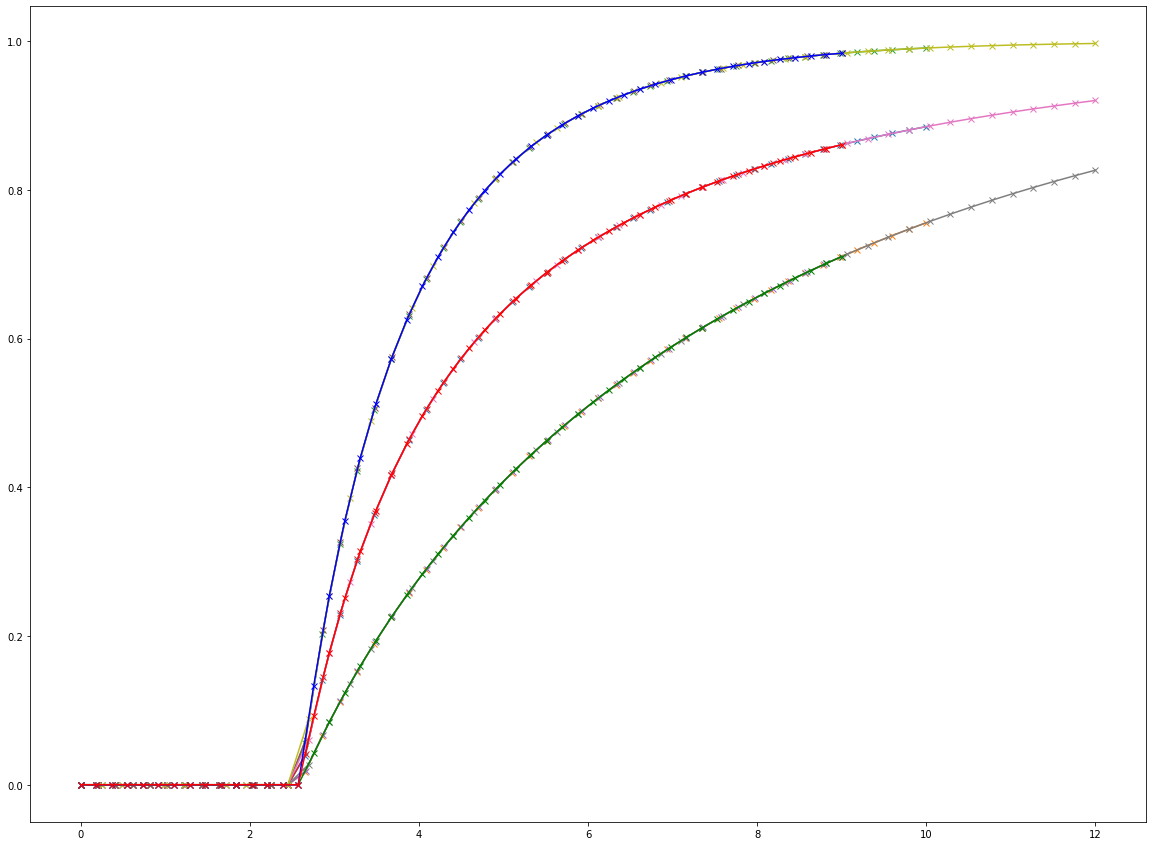

In [46]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(mean_degree_list_0to10, pe_0to10, 'x-')
ax.plot(mean_degree_list_0to10, pe0_0to10, 'x-')
ax.plot(mean_degree_list_0to10, pe1_0to10, 'x-')
ax.plot(mean_degree_list_0to9, pe_0to9, 'x-')
ax.plot(mean_degree_list_0to9, pe0_0to9, 'x-')
ax.plot(mean_degree_list_0to9, pe1_0to9, 'x-')
ax.plot(mean_degree_list_0to12, pe_0to12, 'x-')
ax.plot(mean_degree_list_0to12, pe0_0to12, 'x-')
ax.plot(mean_degree_list_0to12, pe1_0to12, 'x-')
plot_anaylsis(pe_0to9_parellel, ax, legend_list, 'x-')
# plot_anaylsis(es_0to10_nosplit, ax, legend_list, '--')